In [1]:
!nvidia-smi

Thu Feb 24 19:23:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7

     |████████████████████████████████| 2.1 MB 12.7 MB/s 
     |████████████████████████████████| 3.3 MB 33.6 MB/s 
     |████████████████████████████████| 895 kB 22.9 MB/s 
     |████████████████████████████████| 830 kB 12.1 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 134 kB 41.1 MB/s 
     |████████████████████████████████| 397 kB 46.7 MB/s 
     |████████████████████████████████| 829 kB 52.8 MB/s 
     |████████████████████████████████| 1.1 MB 2.6 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 144 kB 50.8 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 


In [3]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [4]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

In [6]:
!gdown --id 1GdCk3T-uAXgInOqFR0k3nPBIXRoHIhRM

Downloading...
From: https://drive.google.com/uc?id=1GdCk3T-uAXgInOqFR0k3nPBIXRoHIhRM
To: /content/AllProductReviews.csv
100% 2.51M/2.51M [00:00<00:00, 164MB/s]


In [7]:
df=pd.read_csv("AllProductReviews.csv",encoding="latin-1")
df.head()

,ctext,text,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...ð...,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In [8]:
df=df[["text","ctext"]]
df.head()

,text,ctext
0,No doubt it has a great bass and to a great ex...,Honest review of an edm music lover\n
1,"This earphones are unreliable, i bought it be...",Unreliable earphones with high cost\n
2,"i bought itfor 999,I purchased it second time,...",Really good and durable.\n
3,Its sound quality is adorable. overall it was ...,stopped working in just 14 days\n
4,Its Awesome... Good sound quality & 8-9 hrs ba...,Just Awesome Wireless Headphone under 1000...ð...


In [9]:
df.columns=["summary" , "text"]
df = df.dropna()
df.head()

,summary,text
0,No doubt it has a great bass and to a great ex...,Honest review of an edm music lover\n
1,"This earphones are unreliable, i bought it be...",Unreliable earphones with high cost\n
2,"i bought itfor 999,I purchased it second time,...",Really good and durable.\n
3,Its sound quality is adorable. overall it was ...,stopped working in just 14 days\n
4,Its Awesome... Good sound quality & 8-9 hrs ba...,Just Awesome Wireless Headphone under 1000...ð...


In [10]:
df.shape

(14337, 2)

In [11]:
train_df,test_df=train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((12903, 2), (1434, 2))

In [12]:
from pandas.core.internals.managers import T
class NewsSummaryDataset(Dataset):
  def __init__(
      self,
      data:pd.DataFrame,
      tokenizer: T5Tokenizer,
      text_max_token_len : int =512,
      summary_max_token_len : int =128
  ):
    self.tokenizer=tokenizer
    self.data=data
    self.text_max_token_len= text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def __len__(self):
    return len(self.data)
  def __getitem__(self,index:int):
    data_row = self.data.iloc[index]
    text=data_row["text"]
    text_encoding=tokenizer(text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    summary_encoding=tokenizer(
        data_row["summary"],
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    labels=summary_encoding["input_ids"]
    labels[labels==0]=-100
    return dict(
        text=text,
        summary= data_row["summary"],
        text_input_ids = text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask = summary_encoding["attention_mask"].flatten()
    )



In [13]:
class NewsSummaryDataModule(pl.LightningDataModule):

  def __init__(
      self,
      train_df:pd.DataFrame,
      test_df:pd.DataFrame,
      tokenizer:T5Tokenizer,
      batch_size: int =4,
      text_max_token_len:int=512,
      summary_max_token_len:int=128
  ):
    super().__init__()
    self.train_df=train_df
    self.test_df=test_df
    self.tokenizer=tokenizer
    self.batch_size=batch_size
    self.text_max_token_len=text_max_token_len
    self.summary_max_token_len=summary_max_token_len

  def setup(self,stage=None):
    self.train_dataset=NewsSummaryDataset(
    self.train_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )
    self.test_dataset=NewsSummaryDataset(
    self.test_df,
    self.tokenizer,
    self.text_max_token_len,
    self.summary_max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        
    )



In [14]:
MODEL_NAME="t5-base"
tokenizer=T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [15]:
text_token_counts,summary_token_counts=[],[]
for _,row in train_df.iterrows():
  text_token_count=len(tokenizer.encode(row["text"]))
  text_token_counts.append(text_token_count)
  summary_token_count=len(tokenizer.encode(row["summary"]))
  summary_token_counts.append(summary_token_count)


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary text token counts')

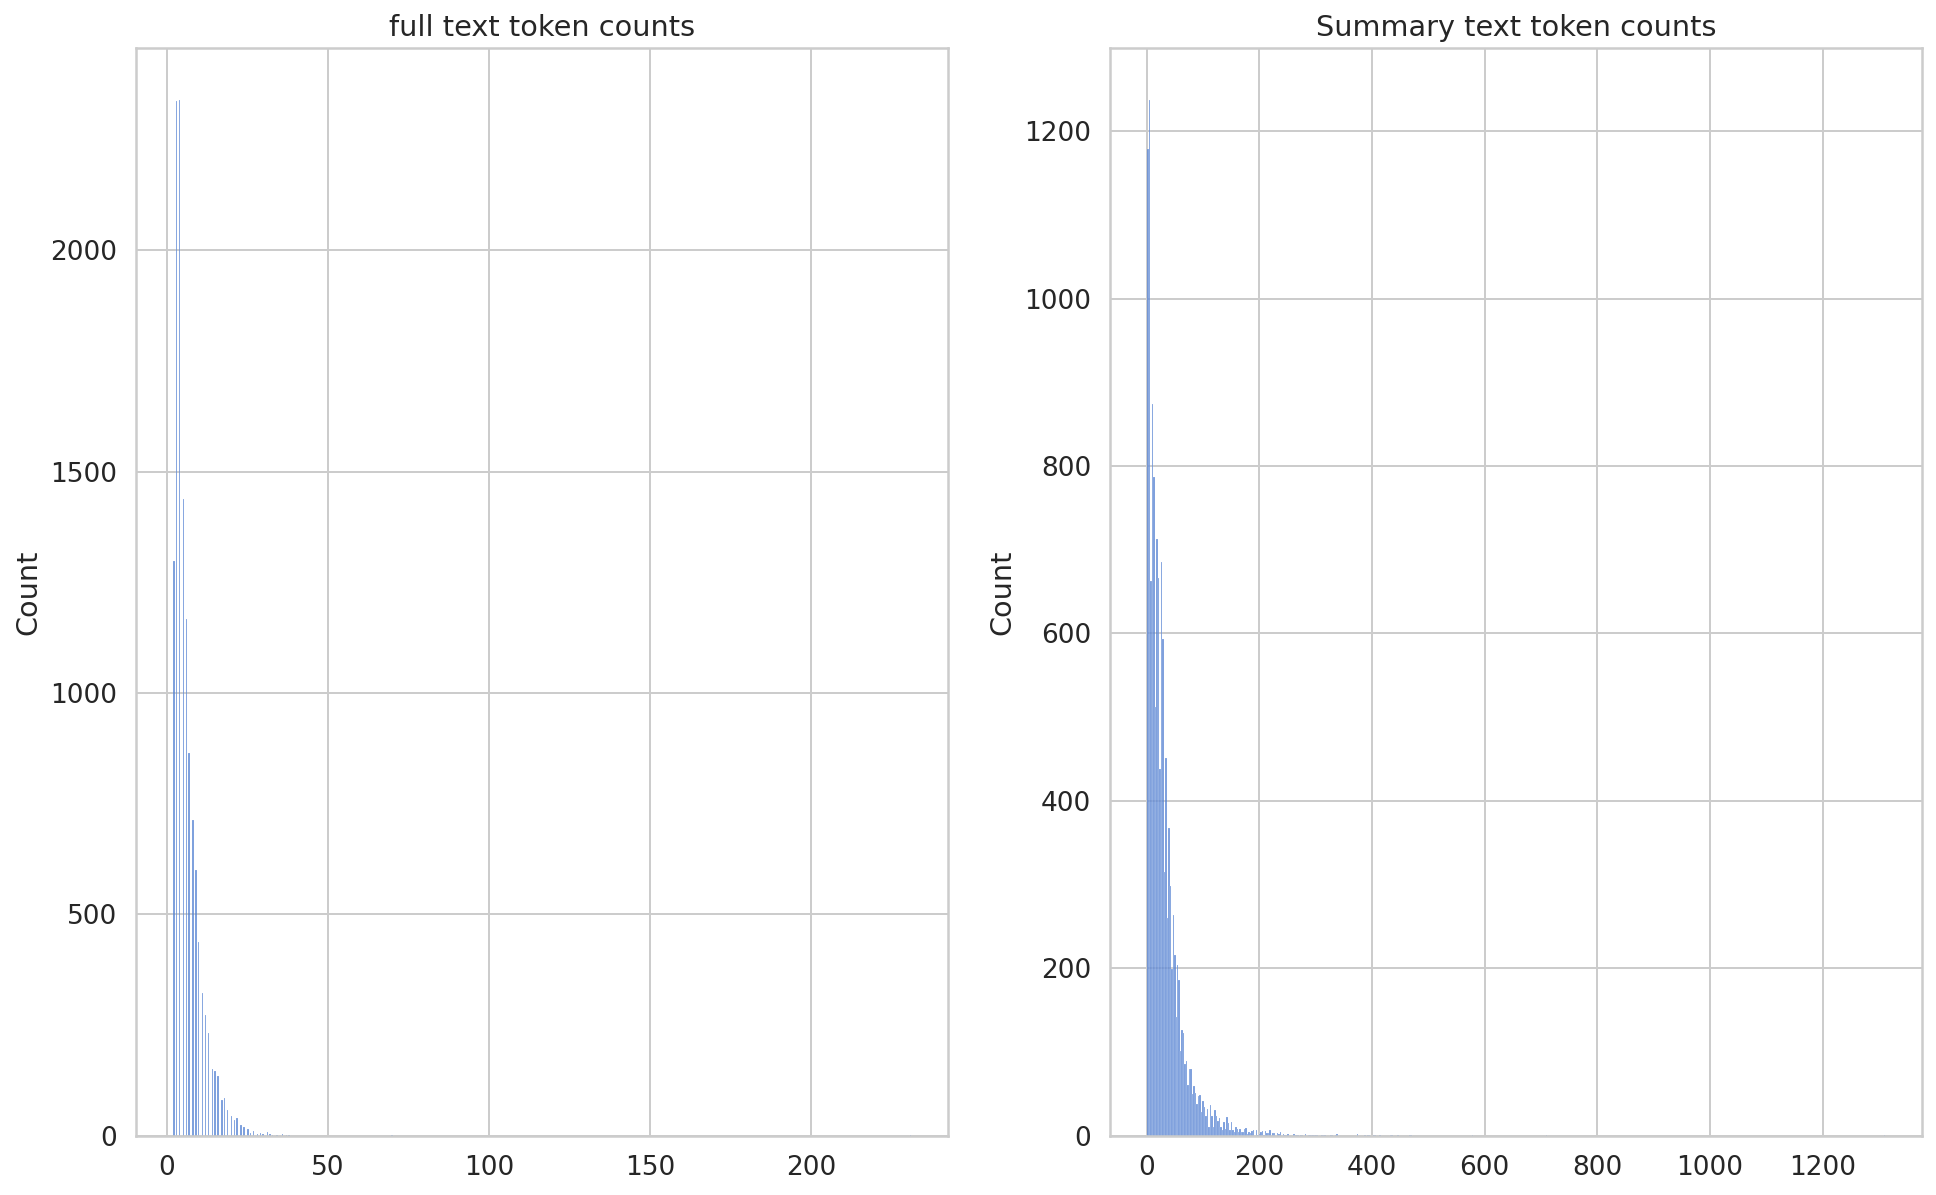

In [16]:
fig ,(ax1,ax2)=plt.subplots(1,2)
sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("full text token counts")
sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")

In [17]:
N_EPOCHS=3
BATCH_SIZE=4
data_module=NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [18]:
class NewsSummaryModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model=T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)
  def forward(self,input_ids,attention_mask,decoder_attention_mask,labels=None):

    output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )
    return output.loss,output.logits

  def training_step(self,batch,batch_idx):
    input_ids=batch["text_input_ids"]
    attention_mask=batch["text_attention_mask"]
    labels=batch["labels"]
    labels_attention_mask=batch["labels_attention_mask"]
    loss,outputs= self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )
    self.log("train_loss",loss,prog_bar=True,logger=True)
    return loss

  def test_step(self,batch,batch_idx):
      input_ids=batch["text_input_ids"]
      attention_mask=batch["text_attention_mask"]
      labels=batch["labels"]
      labels_attention_mask=batch["labels_attention_mask"]
      loss,outputs= self(
          input_ids=input_ids,
          attention_mask=attention_mask,
          decoder_attention_mask=labels_attention_mask,
          labels=labels
      )
      self.log("test_loss",loss,prog_bar=True,logger=True)
      return loss

  def configure_optimizers(self):
      return AdamW(self.parameters(),lr=0.0001)

In [19]:
model=NewsSummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [20]:
%reload_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [21]:
checkpoint_callback=ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="train_loss",
    mode="min"
)
logger=TensorBoardLogger("lightening_logs",name="news-summary")
trainer=pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30,
    
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
trainer.fit(model,data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 3225: train_loss reached 3.63688 (best 3.63688), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 1, global step 6451: train_loss reached 3.53832 (best 3.53832), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 2, global step 9677: train_loss reached 3.41369 (best 3.41369), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


1

In [23]:
trained_model=NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [24]:
def summarize(text):
  text_encoding=tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids=trained_model.model.generate(
      input_ids=text_encoding["input_ids"],
      attention_mask=text_encoding["attention_mask"],
      max_length=150,
      num_beams=2,
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )

  preds=[
         tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
         for gen_id in generated_ids
  ]

  return "".join(preds)

In [25]:
sample_row=test_df.iloc[1]
text=sample_row["text"]
model_summary=summarize(text)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


In [26]:
text

'Must buy earphones\n'

In [27]:
sample_row["summary"]

'Nice product sound quality is good battery life is nice I like it easy to use without worrying about wires and everything\n'

In [28]:
model_summary

'Good earphones'